In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

snowflow_data_fn = 'boise_river_snow2flow.csv'

In [2]:
snowflow_data_df = pd.read_csv(snowflow_data_fn, index_col='datetime')
snowflow_data_df

,prec_mm,tavg_degc,swe_mm,flow_cms
datetime,,,,
2000-10-01,5.08,5.0,0.00,8.693589
2000-10-02,0.00,2.6,0.00,9.061721
2000-10-03,0.00,0.9,0.00,8.806861
2000-10-04,0.00,1.7,0.00,8.778543
2000-10-05,0.00,-0.5,0.00,8.750225
...,...,...,...,...
2025-09-26,0.00,8.9,0.00,7.674145
2025-09-27,0.00,8.7,0.00,7.617510
2025-09-28,0.00,11.5,0.00,7.617510


In [3]:
# Create target data vector
y = snowflow_data_df.flow_cms.values
X = np.column_stack((snowflow_data_df.prec_mm.values,
     snowflow_data_df.tavg_degc.values,
     snowflow_data_df.swe_mm.values))


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 3. Create DMatrix objects for XGBoost
# DMatrix is an optimized data structure for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [18]:
# 4. Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Objective for regression (mean squared error)
    'eval_metric': 'rmse',            # Evaluation metric (Root Mean Squared Error)
    'max_depth': 5,                   # Maximum depth of a tree
    'eta': 0.1,                       # Learning rate (step size shrinkage)
    'subsample': 0.8,                 # Subsample ratio of the training instance
    'colsample_bytree': 0.8,          # Subsample ratio of columns when constructing each tree
    'seed': 42                        # Random seed for reproducibility
}

In [19]:
# 5. Train the XGBoost model
num_rounds = 1000  # Number of boosting rounds (trees)
model = xgb.train(params, dtrain, num_rounds)

In [20]:
# 6. Make predictions on the test set
y_pred = model.predict(dtest)

# 7. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 592.3660
Root Mean Squared Error: 24.3386


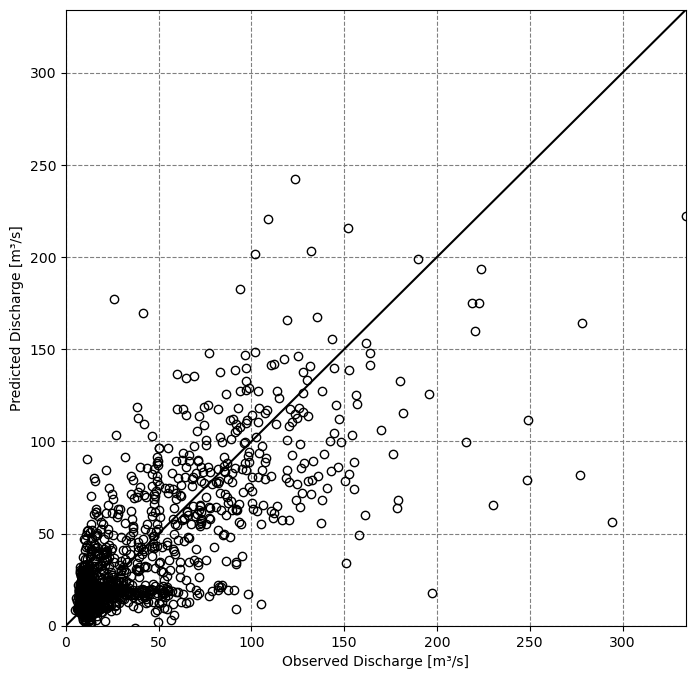

In [21]:
one2one = np.linspace(0,np.max((y_pred.max(),y_test.max())),100)

fig = plt.figure(figsize=(8,8))
plt.plot(y_test,y_pred, marker='o', markerfacecolor='None', markeredgecolor='k', linestyle='None')
plt.plot(one2one,one2one,'k-')
plt.xlim([0, one2one.max()])
plt.ylim([0, one2one.max()])
plt.grid('on',color='grey', linestyle='--')
plt.xlabel('Observed Discharge [m\u00b3/s]')
plt.ylabel('Predicted Discharge [m\u00b3/s]')
plt.show()

## Ways We Could Improve this Model:

- Log-transform the discharge and predict z = ln(y)
- Go deeper in trees - or change/optimize other hyperparameters (e.g., learning rate, subsample, etc.)
- Change the train/test split
- Use a different error metric/objective function
- Bring in additional predictors

Let's use the day of the year as a predictor:

In [ ]:
day_vec = snowflow_data_df.index
day_vec

Index(['2000-10-01', '2000-10-02', '2000-10-03', '2000-10-04', '2000-10-05',
       '2000-10-06', '2000-10-07', '2000-10-08', '2000-10-09', '2000-10-10',
       ...
       '2025-09-21', '2025-09-22', '2025-09-23', '2025-09-24', '2025-09-25',
       '2025-09-26', '2025-09-27', '2025-09-28', '2025-09-29', '2025-09-30'],
      dtype='object', name='datetime', length=9131)

In [31]:
doy = pd.to_datetime(day_vec).day_of_year.values
doy


array([275, 276, 277, ..., 271, 272, 273], shape=(9131,), dtype=int32)

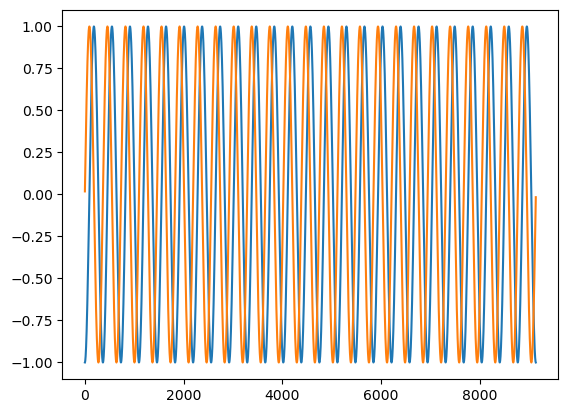

In [33]:
sin_doy = np.sin(doy*2*np.pi/365.25)
cos_doy = np.cos(doy*2*np.pi/365.25)

plt.plot(sin_doy)
plt.plot(cos_doy)